In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
figsize(10, 8)

In [6]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [7]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [8]:
rc = 335.7133441444117
dc = 63.43802542905474

In [9]:
def get_map(bank='A', session='5', doplot=True, pixbeam=4.):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')
    
    return signal, ras, decs, rabins, decbins

In [10]:
def get_map_gal(bank='A', session='5', doplot=True, pixbeam=4.):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    c = coordinates.SkyCoord(ICRS, ra=ras*u.degree, dec=decs*u.degree)
    lats = c.galactic.b.deg
    lons = c.galactic.l.deg
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    pixbeam = beam
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nlatpix = int((lats.max() - lats.min()) / (pixbeam / 60.))
    nlonpix = int((lons.max() - lons.min()) / (pixbeam / 60.))
    
    datamap, hits, lonbins, latbins = naive_map(calibrated, lons, lats, nlonpix, nlatpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(lonbins, latbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('Lon [degrees]')
        ylabel('Lat [degrees]')
        cb.set_label('Flux [Jy]')
    
    return signal, lats, lons, latbins, lonbins

/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


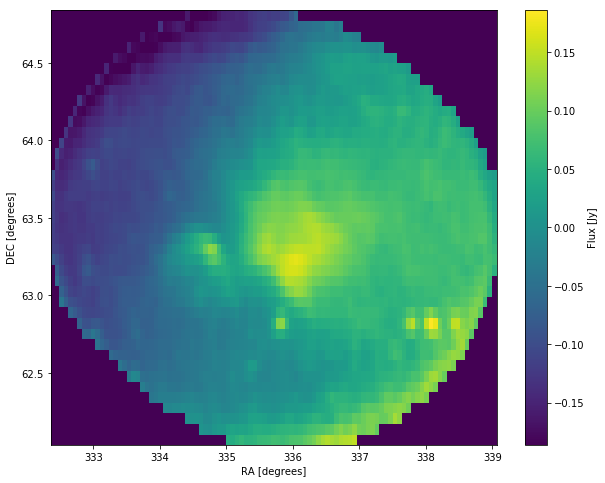

In [11]:
signal, ras, decs, rabins, decbins = get_map()

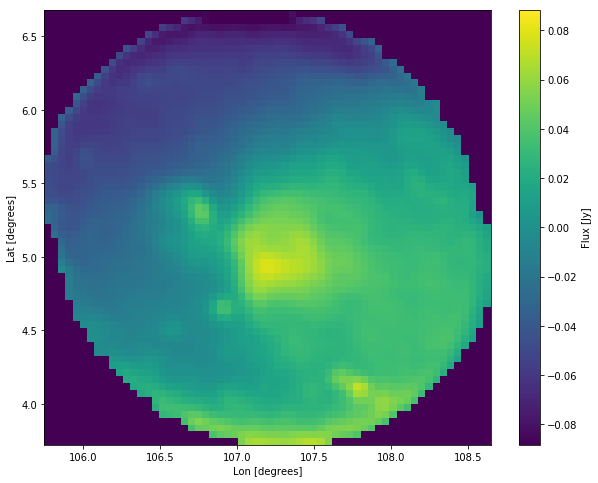

In [12]:
signal, lats, lons, latbins, lonbins = get_map_gal()

In [13]:
lonbinsc = (lonbins[1:] + lonbins[:-1]) / 2.
latbinsc = (latbins[1:] + latbins[:-1]) / 2.

In [17]:
rabinsc = (rabins[1:] + rabins[:-1]) / 2.
decbinsc = (decbins[1:] + decbins[:-1]) / 2.
X, Y = np.meshgrid(rabinsc, decbinsc)
XX = X.flatten()
YY = Y.flatten()
Z = signal.flatten()
mask = ~np.isnan(Z)
data = np.c_[XX[mask], YY[mask], Z[mask]]
A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
C, _, _, _ = linalg.lstsq(A, data[:, 2])
res = C[0] * X + C[1] * Y + C[2]

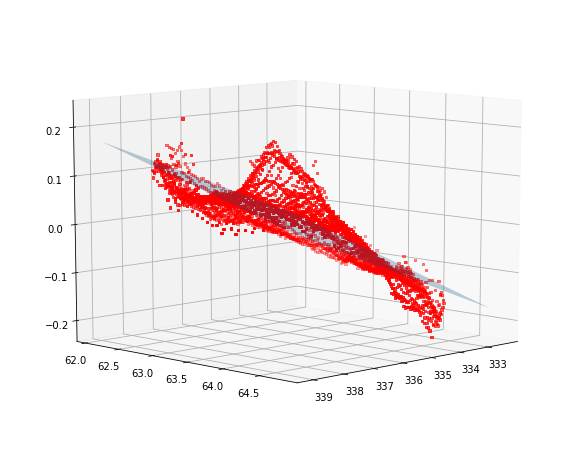

In [18]:
fig = figure()
ax = fig.gca(projection="3d")
ax.plot_surface(X, Y, res, rstride=1, cstride=1, alpha=0.3)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', marker=',', s=5)
ax.view_init(10, 45)

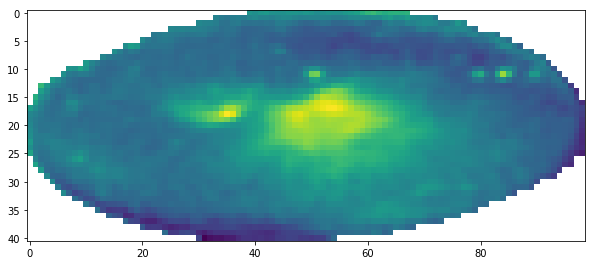

In [19]:
imshow(signal-res)

In [65]:
def calculate_sflux(bank='A', session='5', doplot=False, pixbeam=4., removeplane=False, order=1):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    rmask = radius <= 1.
    
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        mask = ~np.isnan(Z) * (~innerregion.flatten()) * (~outerregion.flatten())
        data = np.c_[XX[mask], YY[mask], Z[mask]]
        data2 = np.c_[XX, YY, Z]
        if order == 1:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
            C, _, _, _ = linalg.lstsq(A, data[:, 2])
            res = C[0] * X + C[1] * Y + C[2]
            #res = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C.rshape(X.shape))
        elif order == 2:
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), data[:,:2]**2]
            C, _, _, _ = linalg.lstsq(A, data[:, 2])
            res = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
        
        signal -= res
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')
        
        fig = figure()
        ax = fig.gca(projection="3d")
        ax.plot_surface(X, Y, res, rstride=1, cstride=1, alpha=0.3)
        ax.scatter(data2[:,0], data2[:,1], data2[:,2], c='r', marker=',', s=5)
        ax.view_init(60, 30)
    
    flux = np.nansum(signal[innerregion] - np.nanmedian(signal[outerregion]))
    return flux

41.6376508959


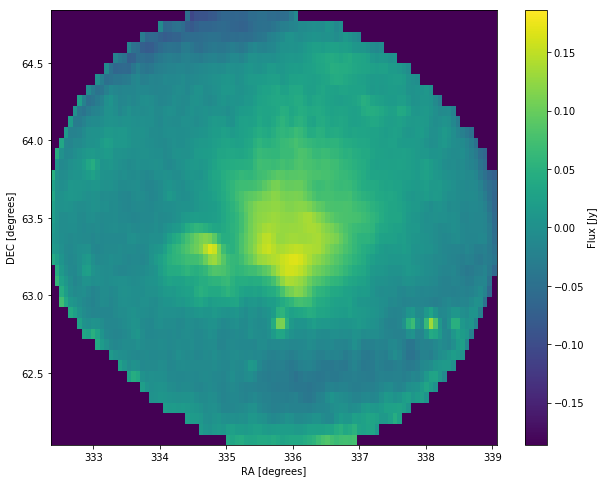

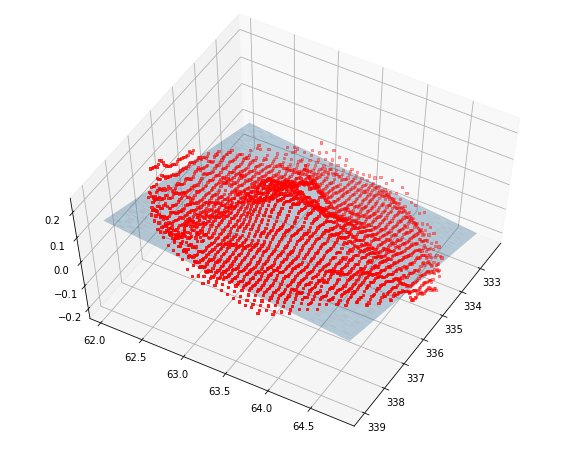

In [66]:
print calculate_sflux('A', removeplane=True, doplot=True)

27.9406849532


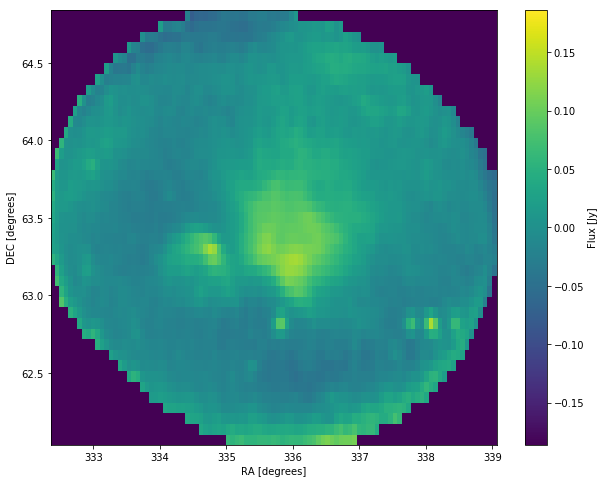

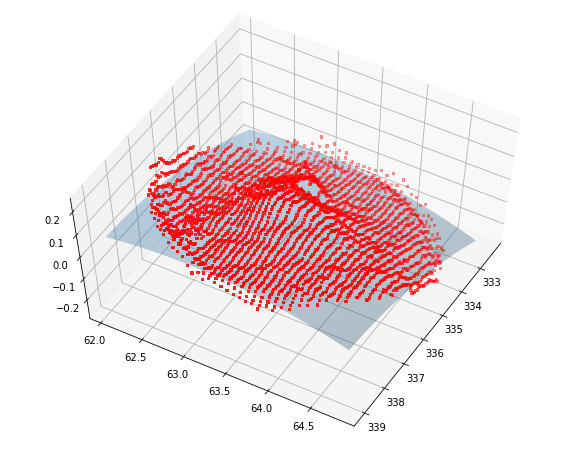

In [67]:
print calculate_sflux('A', removeplane=True, doplot=True, order=2)

41.6376508959
38.7704370922
38.3415259307
30.2057684669


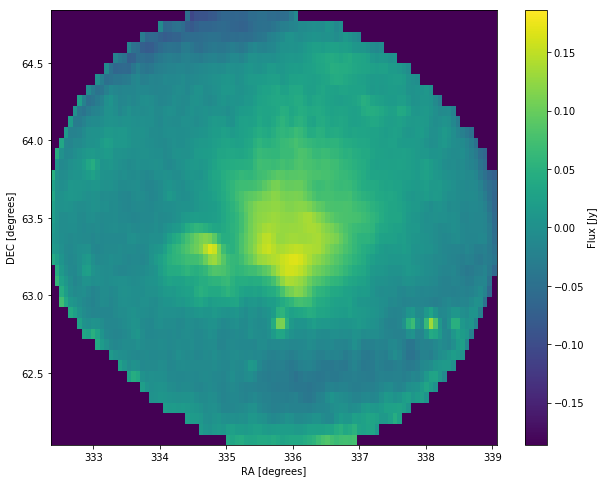

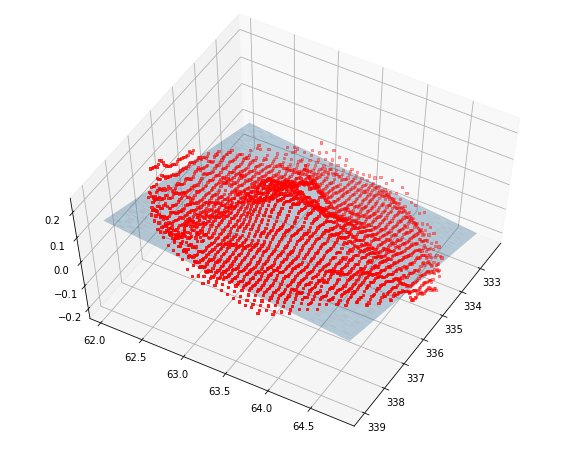

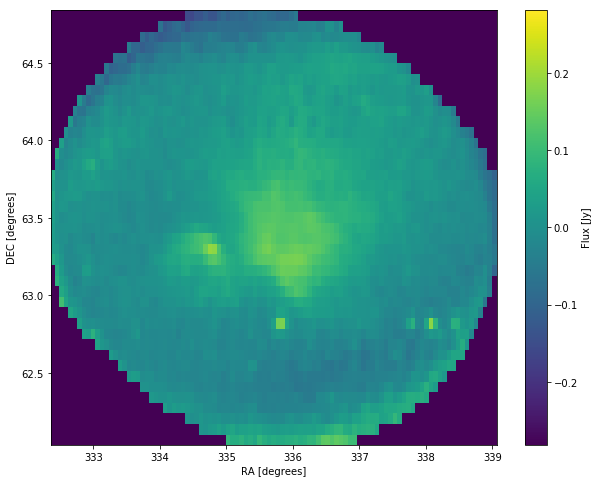

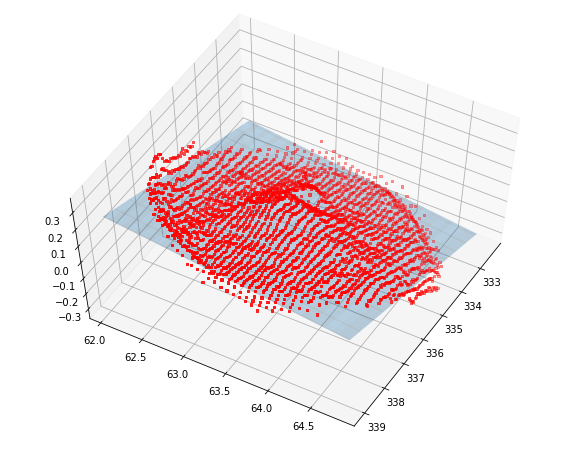

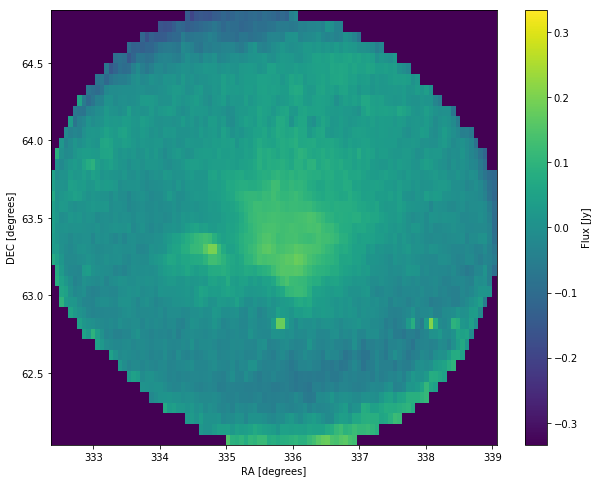

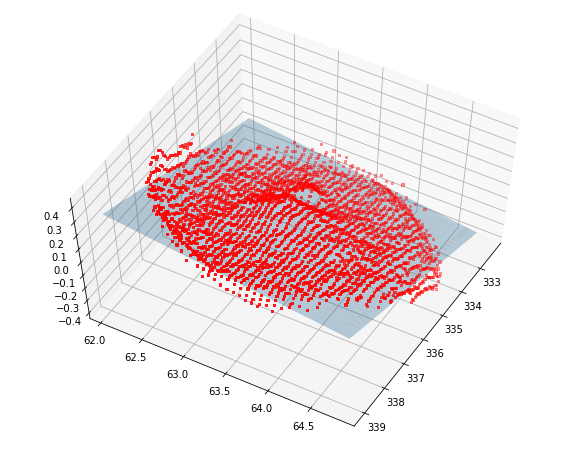

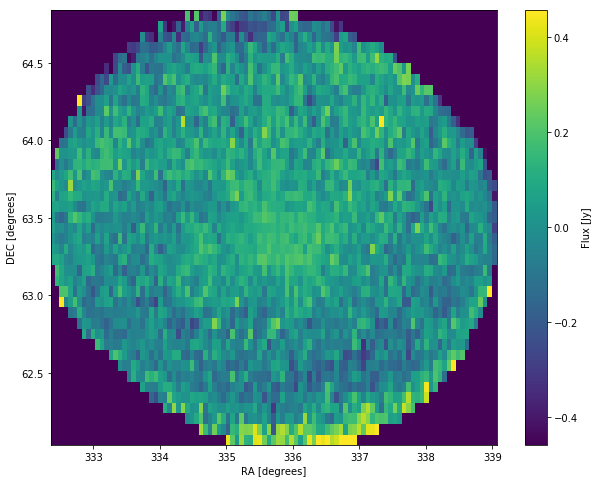

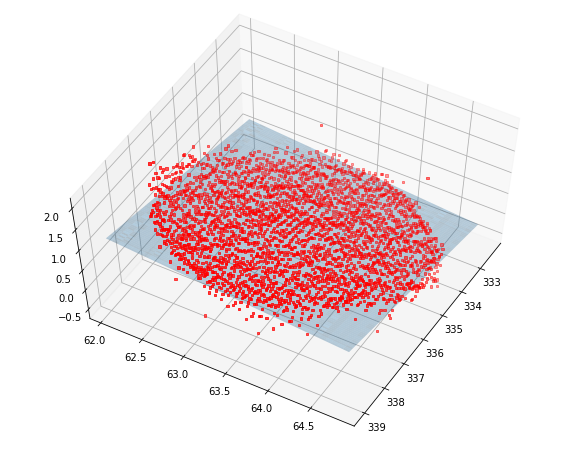

In [68]:
print calculate_sflux('A', removeplane=True, doplot=True)
print calculate_sflux('B', removeplane=True, doplot=True)
print calculate_sflux('C', removeplane=True, doplot=True)
print calculate_sflux('D', removeplane=True, doplot=True)

In [71]:
fluxs2 = []
fluxs2a = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2', removeplane=True))
    fluxs2a.append(calculate_sflux(bank, '2', removeplane=False))

In [72]:
fluxs3 = []
fluxs3a = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3', removeplane=True))
    fluxs3a.append(calculate_sflux(bank, '3', removeplane=False))

In [73]:
fluxs5 = []
fluxs5a = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5', removeplane=True))
    fluxs5a.append(calculate_sflux(bank, '5', removeplane=False))

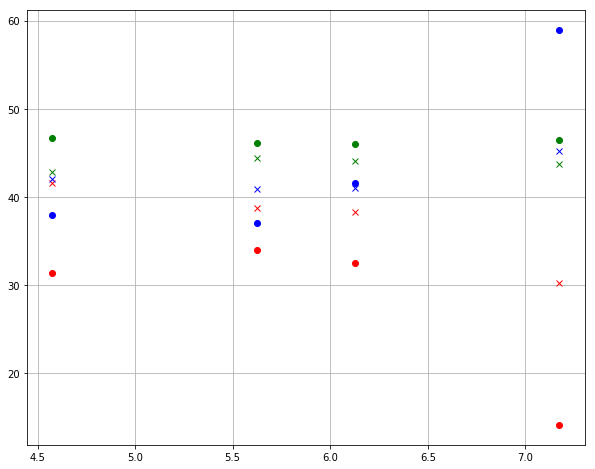

In [74]:
plot(freqs, fluxs5, 'rx')
plot(freqs, fluxs2, 'bx')
plot(freqs, fluxs3, 'gx')
plot(freqs, fluxs5a, 'ro')
plot(freqs, fluxs2a, 'bo')
plot(freqs, fluxs3a, 'go')
grid()

In [75]:
bigflux = np.vstack([fluxs2, fluxs3, fluxs5])

In [76]:
bigflux.std(0) / bigflux.mean(0) * 100.

array([  1.20067332,   5.6534411 ,   5.69725971,  16.97867757])

In [77]:
bigflux.mean(0)

array([ 42.1843427 ,  41.37946338,  41.16393256,  39.698723  ])

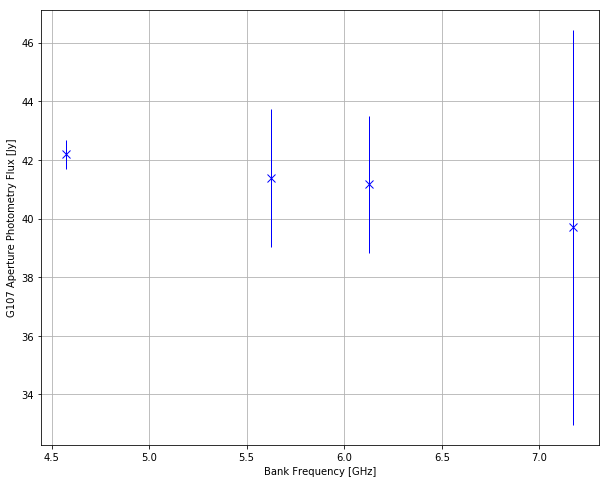

In [78]:
errorbar(freqs, bigflux.mean(0), yerr=bigflux.std(0), fmt='x', color='b', linewidth=1, markersize=8)
grid()
xlabel('Bank Frequency [GHz]')
ylabel('G107 Aperture Photometry Flux [Jy]')